# Multiclass text classification using BERT
- toc: true
- badges: true
- categories: [Natural Language Processing, Hugging Face]
- permalink: /bert-multiclass-text-classification/
- description: a tutorial on mult-class text classfication using pretrained BERT model from HuggingFace

In this post, we'll do a simple text classification task using the pretained [BERT model]((https://huggingface.co/docs/transformers/model_doc/bert) from HuggingFace.

The BERT model was proposed in [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805), by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova.


In [1]:
#hide
#!pip install transformers
import pandas as pd


In [ ]:
#hide
import warnings
warnings.filterwarnings("ignore")

## Loading data



In [ ]:

PRETRAINED_LM = "aubmindlab/bert-large-arabertv2"
%mkdir PRI_PADT
TB_path="/content/PRI_PADT"

In [ ]:
BATCH_SIZE = 64


In [2]:
def build_data(in_file,POS):

    import csv

    max_length=0

    # Open the input file in read mode
    input_file = open(in_file+".conllu", "r")

    # Create an empty list to store the lines
    words = ""
    root= ""
    csv_line=[]



    with open(in_file+".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["text","label"])
        root_found=False
        # Loop through each line in the input file
        c=0
        for line in input_file:

          if line!="\n":
                words=words+(line.split()[1])+" "
                if line.split()[6]=="0" and not root_found:
                  root=POS[line.split()[3]]
                  root_found=True

          else:
                c+=1
                full_text=words[0:-1]
                root_found=False
                if len(words)>max_length: max_length= len(words.split(" "))
                csv_line.append(full_text)
                csv_line.append(str(root))
                writer.writerow(csv_line)


                csv_line=[]
                words = ""
                root= ""

    print('max_length',max_length,"\n","count of examples:",c)
    # Close the input file
    input_file.close()




In [3]:

POS={}
label_names=set()

for f in ["train","dev","test"]:
   temp_pos=set()
   input_file = open(f+".conllu", "r")
   for line in input_file:
    if line!="\n":
      if line.split()[6]=="0":
        label_names.add(line.split()[3])
        temp_pos.add(line.split()[3])
   print(f,len(temp_pos),"\n",temp_pos)

label_names=list(label_names)
for i in range(len(label_names)):
  POS[label_names[i]]=i



build_data("/content/train",POS)
build_data("/content/dev",POS)
build_data("/content/test",POS)


N_labels = len(label_names)
print(POS)
print(label_names)
print("N_labels: ",N_labels)

train_df=pd.read_csv("train.csv")
valid_df=pd.read_csv("dev.csv")
test_df=pd.read_csv("test.csv")



def count_pos(df,df_name):
    print("\n ---", df_name,"---\n")
    for i in range(N_labels):
        counter = len(df.loc[df['label'] == i])
        print(i,counter)

count_pos(train_df,"train")
count_pos(valid_df,"dev")
count_pos(test_df,"test")

train 14 
 {'CCONJ', 'SCONJ', 'DET', 'X', 'NOUN', 'PRON', 'NUM', 'VERB', 'PUNCT', 'PART', 'ADJ', 'ADV', 'ADP', 'PROPN'}
dev 11 
 {'CCONJ', 'DET', 'X', 'NOUN', 'PRON', 'VERB', 'NUM', 'PART', 'ADJ', 'ADV', 'ADP'}
test 10 
 {'CCONJ', 'DET', 'X', 'NOUN', 'VERB', 'NUM', 'PART', 'ADJ', 'ADV', 'ADP'}
max_length 38 
 count of examples: 6075
max_length 38 
 count of examples: 909
max_length 24 
 count of examples: 680
{'CCONJ': 0, 'SCONJ': 1, 'DET': 2, 'X': 3, 'NOUN': 4, 'PRON': 5, 'NUM': 6, 'VERB': 7, 'PUNCT': 8, 'PART': 9, 'ADJ': 10, 'ADV': 11, 'ADP': 12, 'PROPN': 13}
['CCONJ', 'SCONJ', 'DET', 'X', 'NOUN', 'PRON', 'NUM', 'VERB', 'PUNCT', 'PART', 'ADJ', 'ADV', 'ADP', 'PROPN']
N_labels:  14

 --- train ---

0 3196
1 3
2 22
3 376
4 664
5 7
6 97
7 1572
8 5
9 13
10 109
11 4
12 3
13 4

 --- dev ---

0 564
1 0
2 4
3 58
4 100
5 1
6 7
7 157
8 0
9 5
10 11
11 1
12 1
13 0

 --- test ---

0 385
1 0
2 2
3 36
4 56
5 0
6 13
7 175
8 0
9 2
10 9
11 1
12 1
13 0


In [ ]:
train_df.head()

,text,label
0,برلين ترفض حصول شركة اميركية على رخصة تصنيع دب...,12
1,برلين 15 - 7 ( اف ب ) - افادت صحيفة الاحد الال...,6
2,و في نيسان / ابريل الماضي ، تخلت الدولة الاسبا...,0
3,و كانت خسائر المجموعة الاسبانية الرسمية تراكمت...,0
4,و أشارت صحيفة الاحد الى ان المستشار شرودر يعتب...,0


## Tokenization

Tokenization is a process for spliting raw texts into tokens, and encoding the tokens into numeric data.

To do this, we first initialize a `BertTokenizer`:

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

BertTokenizer(name_or_path='aubmindlab/bert-large-arabertv2', vocab_size=64000, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

define a function for encoding:

In [ ]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

Use the `ecode` function to get input ids and attention masks of the datasets:

In [ ]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(valid_df['text'].values.tolist())
test_input_ids, test_att_masks = encode(test_df['text'].values.tolist())

<br>

## Creating `Dataset`s and `DataLoader`s

We'll use pytorch `Dataset` and `DataLoader` to split data into batches. For more detatils, you can check out another post on [DataLoader](https://www.intodeeplearning.com/how-to-load-datasets-from-hugging-face-datasets/).

Turn the labels into tensors:

In [ ]:
import torch
train_y = torch.LongTensor(train_df['label'].values.tolist())
valid_y = torch.LongTensor(valid_df['label'].values.tolist())
test_y = torch.LongTensor(test_df['label'].values.tolist())
train_y.size(),valid_y.size(),test_y.size()

(torch.Size([6075]), torch.Size([909]), torch.Size([680]))

Create dataloaders for training

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

<br>

## Bert For Sequence Classification Model

We will initiate the  `BertForSequenceClassification ` model from Huggingface, which allows easily fine-tuning the pretrained BERT mode for classification task.


You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained.

In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-large-arabertv2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.cuda()

<br>

## Fine-tuning

### **Optimizer and Scheduler**

An **optimizer** is for tuning parameters in the model, which is set up with a learning rate.

Selection of the learning rate is important. In practice, it's common to use a **scheduler** to decrease the learning rate during training.

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 30
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

<br>

### **Training Loop**

The training loop is where the magic of deep learning happens. The model will be fine-tuned on the emotion dataset for classification task.

In [ ]:
#collapse-output
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 1.8306773813147295 
15/15 val loss: 1.4932517846425375 
Epoch:  2


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 1.4130600075972708 
15/15 val loss: 1.2641809463500977 
Epoch:  3


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 1.2608662981736032 
15/15 val loss: 1.156692119439443 
Epoch:  4


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 1.117785710410068 
15/15 val loss: 0.9667953968048095 
Epoch:  5


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.9529307478352597 
15/15 val loss: 0.8064679781595866 
Epoch:  6


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.839417132578398 
15/15 val loss: 0.7581128776073456 
Epoch:  7


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.7456193265162017 
15/15 val loss: 0.6956128080685934 
Epoch:  8


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.6820008516311645 
15/15 val loss: 0.6613908290863038 
Epoch:  9


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.633926512693104 
15/15 val loss: 0.630280077457428 
Epoch:  10


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.5971904685622768 
15/15 val loss: 0.6067796419064204 
Epoch:  11


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.5747997807829004 
15/15 val loss: 0.58590141137441 
Epoch:  12


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.5498013245432001 
15/15 val loss: 0.5706079085667928 
Epoch:  13


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.5316438753353921 
15/15 val loss: 0.5604258040587108 
Epoch:  14


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.5121445740524091 
15/15 val loss: 0.5493033230304718 
Epoch:  15


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.48891860591737846 
15/15 val loss: 0.5488966306050619 
Epoch:  16


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.4710796872251912 
15/15 val loss: 0.5434369057416916 
Epoch:  17


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.46219094301524916 
15/15 val loss: 0.5417204608519872 
Epoch:  18


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.4497426415744581 
15/15 val loss: 0.5342607061068217 
Epoch:  19


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.43145164031731453 
15/15 val loss: 0.5315118183692297 
Epoch:  20


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.4177980647275322 
15/15 val loss: 0.5289581000804902 
Epoch:  21


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.4133900323980733 
15/15 val loss: 0.5195821980635326 
Epoch:  22


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.40055174153102074 
15/15 val loss: 0.5165517300367355 
Epoch:  23


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.3993508022082479 
15/15 val loss: 0.5093743900458018 
Epoch:  24


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.3833476033649946 
15/15 val loss: 0.5066659102837244 
Epoch:  25


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.37503817473587236 
15/15 val loss: 0.5009578044215838 
Epoch:  26


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.378761415105117 
15/15 val loss: 0.5005575319131216 
Epoch:  27


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.38619095855637603 
15/15 val loss: 0.4988946422934532 
Epoch:  28


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.3741782122536709 
15/15 val loss: 0.4981264054775238 
Epoch:  29


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.37563715326158625 
15/15 val loss: 0.4962964355945587 
Epoch:  30


Training:   0%|          | 0/95 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

95/95 train loss: 0.3761751107479397 
15/15 val loss: 0.49576730926831564 


You can see in the output that the training and validation losses steadily decreases in each epoch.

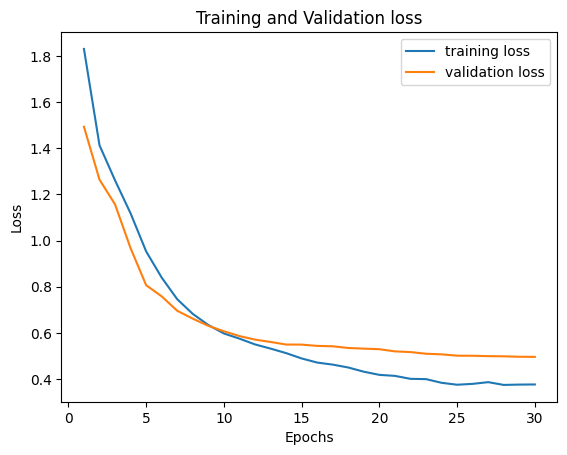

In [ ]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

## Performance Metrics
It's common to use precision, recall, and F1-score as the performance metrics.

In [ ]:
from sklearn.metrics import classification_report
#print('classifiation report')
#print(classification_report(valid_pred, valid_df['label'].to_numpy(), target_names=label_names))

## Error Analysis
With the predictions, we can plot the confusion matrix:

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

In [ ]:
#plot_confusion_matrix(valid_pred,valid_df['label'].to_numpy(),labels=label_names)

You can see that **sadness** has a higher likelihood to be classified as **anger** or **fear**, leading to a lower f1 score.

<br>

## Prediction

*Now* let's use the trained model to predict the testing set.

In [ ]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [ ]:
from sklearn.metrics import classification_report,accuracy_score
print('classifiation report\n')
print("pos count_in_pred")

for pos in set(test_pred):
  print(label_names[pos],list(test_pred).count(pos))
print("\n\npos count_in_test")
for pos in set(test_df['label'].to_numpy()):
  print(label_names[pos],list(test_df['label'].to_numpy()).count(pos))

print("\n\n Accuracy: ",round(accuracy_score(test_pred, test_df['label'].to_numpy())*100,2))
#print(classification_report(test_pred, test_df['label'].to_numpy(),target_names=label_names))

classifiation report

pos count_in_pred
CCONJ 386
NOUN 76
VERB 188
X 30


pos count_in_test
CCONJ 385
DET 2
ADP 1
PART 2
X 36
NUM 13
ADJ 9
NOUN 56
VERB 175
ADV 1


 Accuracy:  91.32


With the predictions, we can plot the confusion matrix again:

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
plot_confusion_matrix(test_pred,test_df['label'].to_numpy(),labels=label_names)

Output the misclassified text:

In [ ]:
test_df['pred'] = test_pred
test_df.reset_index(level=0)
print(test_df[test_df['label']!=test_df['pred']].shape)
test_df[test_df['label']!=test_df['pred']][['text','label','pred']].head(10)

(59, 3)


,text,label,pred
0,سوريا : تعديل وزاري واسع يشمل 8 حقائب,6,11
29,قرطاج ( وات ) كان نشاط الحكومة و برنامج عمل ها...,6,11
38,بيروت ( وكالات الأنباء ) - رأى محللون امس ان ا...,11,6
50,ثم استقال اربعة وزراء و انضموا الى المعارضة مم...,0,12
52,بعدما لجأ عدد من هم الى القضاء ل الاعتراض على ...,11,12
56,محمد صلاح - حازم محمد,6,11
70,محمود شحاتة,6,11
89,لـ » الحياة « إن » الإخوان « س يساندون عطية » ...,3,12
126,مرشحو » الاخوان « 16 . . . إذا لم يعتقلوا,7,11
140,852 مرشحاً ل انتخابات مجلس الشورى و تكريس ظاهر...,7,11


In [ ]:
#hide

test_df.to_csv(TB_path+"/test_results.csv",index= False)
valid_df.to_csv(TB_path+"/dev_results.csv",index= False)

In [ ]:

from google.colab import files
%cd /content/





!zip -r PRI_PADT.zip PRI_PADT
files.download('PRI_PADT.zip')


/content
  adding: PRI_PADT/ (stored 0%)
  adding: PRI_PADT/dev_results.csv (deflated 72%)
  adding: PRI_PADT/test_results.csv (deflated 73%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>